<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity


## WIP



In [27]:
import sys
sys.path.append("../../image_classification") # to get the utilities of image classication (utils_ic)
sys.path.append("..") # to get the utilities of image similarity (utils_is)

from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import fastai
from fastai.vision import *
from fastai.callbacks.hooks import *
from torch.cuda import get_device_name
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook

from utils_ic.gpu_utils import gpu_info
from utils_ic.datasets import Urls, unzip_url
from utils_ic.imagenet_models import model_to_learner

from utils_is.metrics import compute_vector_distance

print(f"Fast.ai version = {fastai.__version__}")
print(f"Machine's GPU info = {gpu_info()} (memory unit = MiB)")
print(f"Fast.ai/Torch is using {get_device_name(0)}")

Fast.ai version = 1.0.50.post1
Machine's GPU info = [{'device_name': 'Tesla P100-PCIE-16GB', 'total_memory': '16280', 'used_memory': '3562'}] (memory unit = MiB)
Fast.ai/Torch is using Tesla P100-PCIE-16GB


In [28]:
DATA_PATH     = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EPOCHS        = 5
LEARNING_RATE = 1e-4
IMAGE_SIZE    = 244
BATCH_SIZE    = 2
ARCHITECTURE  = models.resnet18

In [29]:
path = Path(DATA_PATH)
path.ls()

[PosixPath('/data/home/recocat/notebooks/miguel/ComputerVisionBestPractices/image_classification/data/fridgeObjects/models'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVisionBestPractices/image_classification/data/fridgeObjects/milk_bottle'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVisionBestPractices/image_classification/data/fridgeObjects/can'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVisionBestPractices/image_classification/data/fridgeObjects/water_bottle'),
 PosixPath('/data/home/recocat/notebooks/miguel/ComputerVisionBestPractices/image_classification/data/fridgeObjects/carton')]

In [30]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageList.from_folder(path)
        #.split_by_rand_pct(0.01)
        .split_none()
        .label_from_folder()
        .transform(tfms=tfms, size=IMAGE_SIZE)
        .databunch(bs=BATCH_SIZE))

In [31]:
print('Number of classes {0}'.format(data.c))
print(data.classes)

Number of classes 4
['can', 'carton', 'milk_bottle', 'water_bottle']


In [32]:
print('Train dataset size: {0}'.format(len(data.train_ds.x)))

Train dataset size: 134


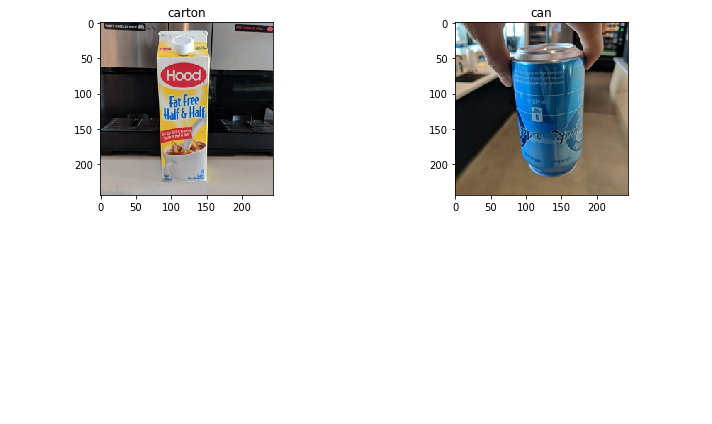

In [33]:
## Show sample data
data.show_batch(rows=3, figsize=(10,6), hide_axis=False) 

In [34]:
## Creating the model
learn = cnn_learner(data, ARCHITECTURE, pretrained=True, metrics=accuracy)

In [35]:
resnet18 = models.resnet18(pretrained=True)
# Chop-off last FC layer
print(list(resnet18.children())[:-1])
chopped_resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])
chopped_resnet18.cuda()
learn.model = chopped_resnet18

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (b

In [40]:
preds,y = learn.get_preds(ds_type=DatasetType.Train)
print(preds.shape)
shapes = list(preds.shape[1:])
features = preds.view(-1, np.prod(shapes)).cpu().numpy()
print(features.shape)
print(len(y))
print(y)

torch.Size([134, 512, 2, 2])
(134, 2048)
134
tensor([3, 1, 3, 2, 3, 3, 2, 1, 1, 2, 2, 0, 2, 1, 1, 3, 1, 0, 0, 1, 0, 2, 3, 0,
        1, 3, 0, 0, 0, 1, 0, 2, 2, 2, 3, 0, 0, 2, 1, 3, 1, 1, 1, 2, 3, 1, 2, 1,
        2, 2, 0, 3, 3, 1, 2, 0, 2, 1, 3, 0, 0, 0, 2, 0, 2, 2, 3, 3, 0, 2, 1, 1,
        0, 3, 3, 3, 0, 2, 3, 3, 0, 2, 0, 1, 2, 0, 1, 3, 1, 3, 2, 3, 0, 0, 2, 2,
        3, 2, 3, 1, 1, 0, 3, 0, 1, 3, 2, 3, 0, 2, 2, 0, 1, 3, 0, 1, 0, 2, 2, 2,
        0, 3, 2, 1, 3, 2, 1, 1, 1, 3, 2, 1, 3, 2])


In [42]:
img_path = [str(x) for x in (list(data.train_ds.items)+list(data.valid_ds.items))]
feature_dict = dict(zip(img_path, features))
print(len(feature_dict))
#print(feature_dict)

134


In [43]:
im1 = Path(DATA_PATH, "carton", "im_87.jpg")
feat1 = feature_dict[str(im1)]
print(feat1.shape)
im2 = Path(DATA_PATH, "carton", "im_86.jpg")
feat2 = feature_dict[str(im2)]
print(feat2.shape)
im3 = Path(DATA_PATH, "can", "im_44.jpg")
feat3 = feature_dict[str(im3)]
print(feat3.shape)

(2048,)
(2048,)
(2048,)


In [44]:
print(compute_vector_distance(feat1, feat2, "l2"))
print(compute_vector_distance(feat1, feat3, "l2"))


1.0675551
1.421032
